# 2: Bayesian Optimization - Finding the Optimum Efficiently

1. Understanding how Bayesian Optimization works
2. Optimizing the Branin function (2D benchmark)
3. Comparing BO vs Random Search
4. Visualizing the optimization process

**Key Idea:** Using a Gaussian Process to model the objective function and intelligently choosing where to sample next

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
sys.path.append('..')

from src.gp_core.kernels import RBFKernel
from src.gp_core.gaussian_process import GaussianProcess
from src.bayesian_optimization.optimizer import BayesianOptimizer
from src.bayesian_optimization.acquisition import ExpectedImprovement, UpperConfidenceBound

np.random.seed(42)
print("Imports successful")

Imports successful


## 1. Defining the Branin Function

The Branin function is a classic 2D optimization benchmark:
- Domain: x ∈ [-5, 10], y ∈ [0, 15]
- Has 3 global minima with f(x,y) ≈ 0.398
- We'll maximize -Branin (to find the minimum)

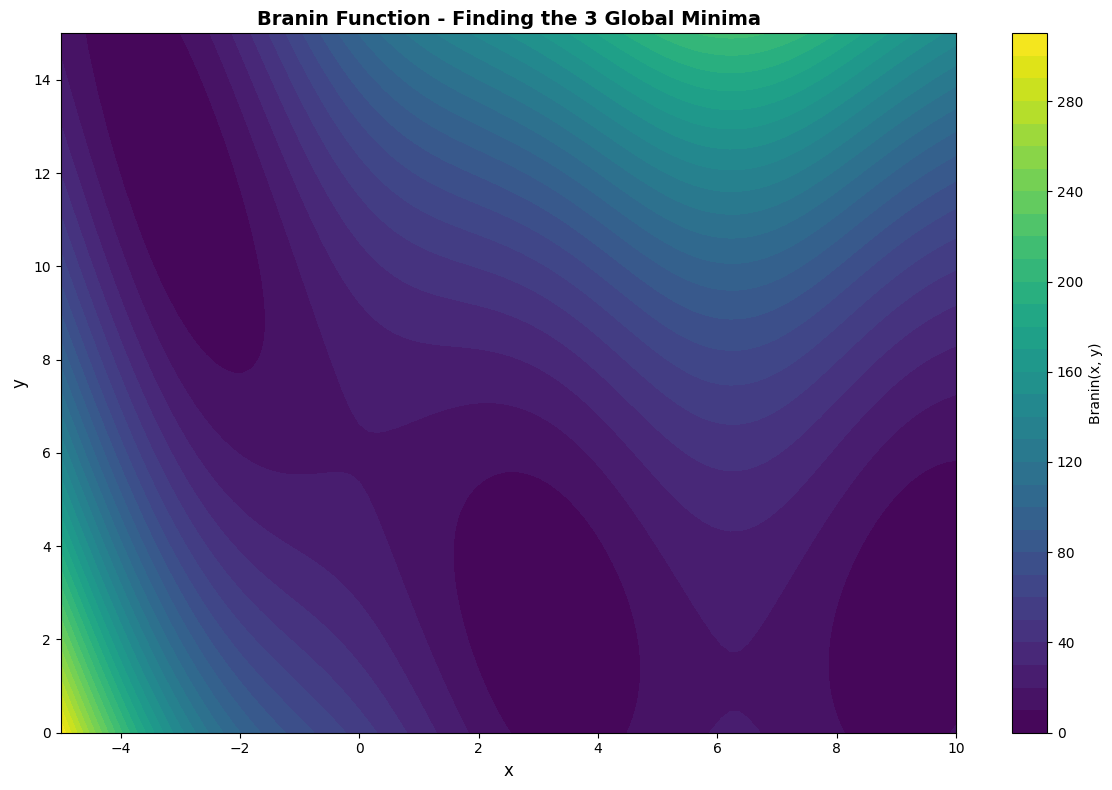

Global minimum value: ~0.398
Global minima locations: (-π, 12.275), (π, 2.275), (9.42478, 2.475)


In [2]:
def branin(x, y):
    """Branin function - standard optimization benchmark."""
    a = 1
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    
    term1 = a * (y - b*x**2 + c*x - r)**2
    term2 = s * (1 - t) * np.cos(x)
    term3 = s
    
    return term1 + term2 + term3

def objective(X):
    """Negative Branin (we want to maximize)."""
    return -branin(X[0], X[1])

# Visualizing the function
x = np.linspace(-5, 10, 100)
y = np.linspace(0, 15, 100)
X_grid, Y_grid = np.meshgrid(x, y)
Z = np.zeros_like(X_grid)

for i in range(len(x)):
    for j in range(len(y)):
        Z[j, i] = branin(X_grid[j, i], Y_grid[j, i])

plt.figure(figsize=(12, 8))
contour = plt.contourf(X_grid, Y_grid, Z, levels=30, cmap='viridis')
plt.colorbar(contour, label='Branin(x, y)')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Branin Function - Finding the 3 Global Minima', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Global minimum value: ~0.398")
print(f"Global minima locations: (-π, 12.275), (π, 2.275), (9.42478, 2.475)")

## 2. Run Bayesian Optimization

In [12]:
# Initializing UCB acquisition function
optimizer = BayesianOptimizer(
    bounds=[(-5, 10), (0, 15)],
    acquisition_function=UpperConfidenceBound(kappa=2.5),
    n_initial=10,
    n_restarts=25,
    random_state=42
)

# Running optimization
result = optimizer.optimize(objective, n_iterations=40, verbose=True)

print(f"\n Result:")
print(f"Best point found: {result['X_best']}")
print(f"Best value (negative Branin): {result['y_best']:.4f}")
print(f"Actual Branin value: {-result['y_best']:.4f}")

Starting Bayesian Optimization
Bounds: [[-5, 10], [0, 15]]
Iterations: 40
Acquisition: UpperConfidenceBound(kappa=2.5)
Iteration 10/40: Best value = -7.8792
Iteration 20/40: Best value = -5.1187
Iteration 30/40: Best value = -2.2609
Iteration 40/40: Best value = -0.4266
Optimization complete!
Best value: -0.4266
Best point: [3.21895116 2.21281606]

 Result:
Best point found: [3.21895116 2.21281606]
Best value (negative Branin): -0.4266
Actual Branin value: 0.4266


## 3. Visualizing the Optimization Path

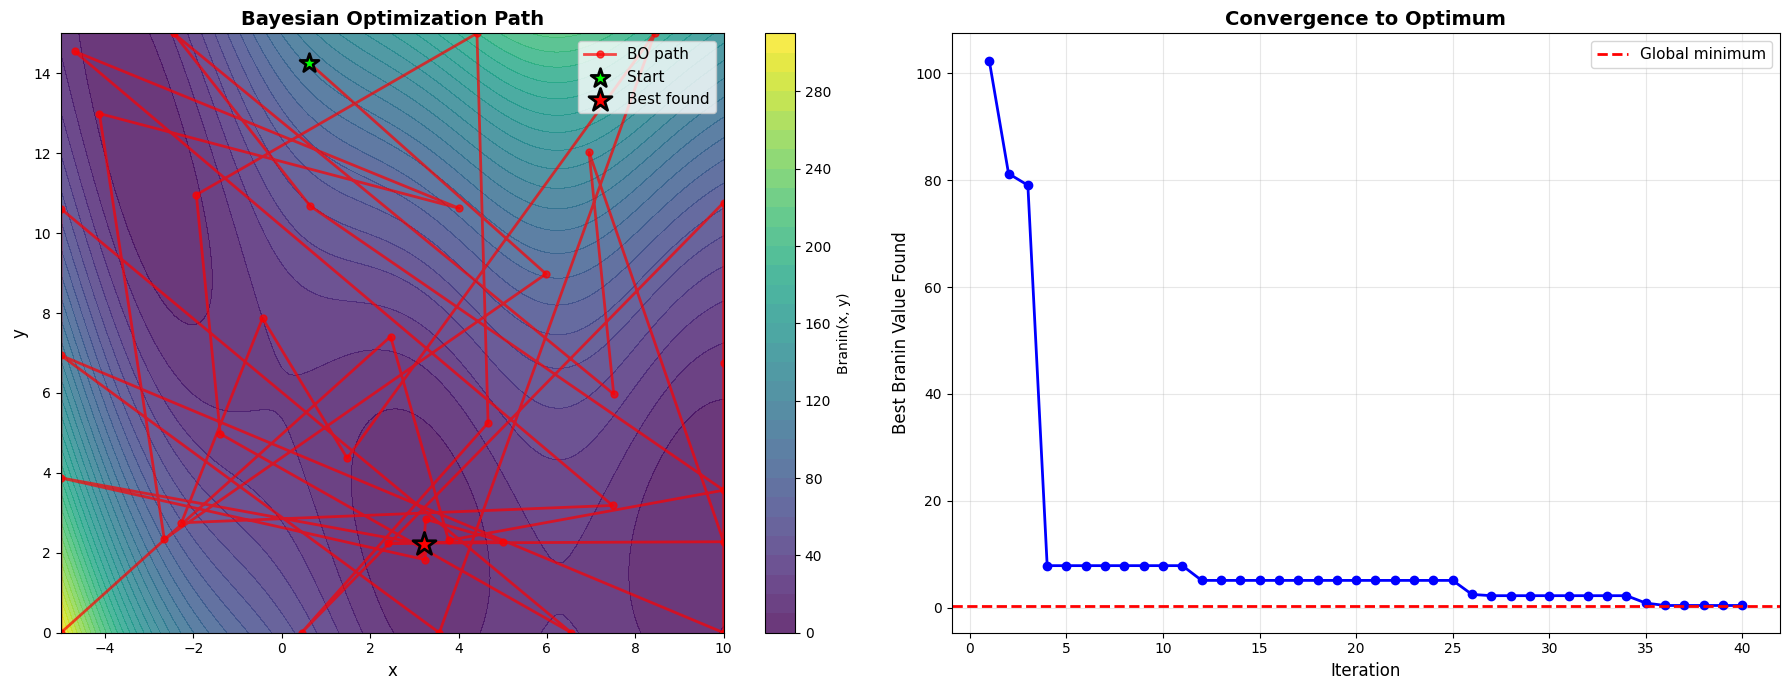

Found minimum in 40 function evaluations


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left plot: Optimization path on contour
ax = axes[0]
contour = ax.contourf(X_grid, Y_grid, Z, levels=30, cmap='viridis', alpha=0.8)
plt.colorbar(contour, ax=ax, label='Branin(x, y)')

# Plotting optimization path
X_obs = result['X_observed']
ax.plot(X_obs[:, 0], X_obs[:, 1], 'r.-', linewidth=2, markersize=10, 
        alpha=0.7, label='BO path')
ax.scatter(X_obs[0, 0], X_obs[0, 1], c='lime', s=200, marker='*', 
          edgecolors='black', linewidths=2, label='Start', zorder=5)
ax.scatter(result['X_best'][0], result['X_best'][1], c='red', s=300, marker='*',
          edgecolors='black', linewidths=2, label='Best found', zorder=5)

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Bayesian Optimization Path', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

# Right plot: Convergence
ax = axes[1]
iterations = np.arange(1, len(result['convergence']) + 1)
ax.plot(iterations, -result['convergence'], 'b-', linewidth=2, marker='o')
ax.axhline(y=0.398, color='r', linestyle='--', linewidth=2, label='Global minimum')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Best Branin Value Found', fontsize=12)
ax.set_title('Convergence to Optimum', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Found minimum in {len(result['y_observed'])} function evaluations")

## 4. Comparing with Random Search

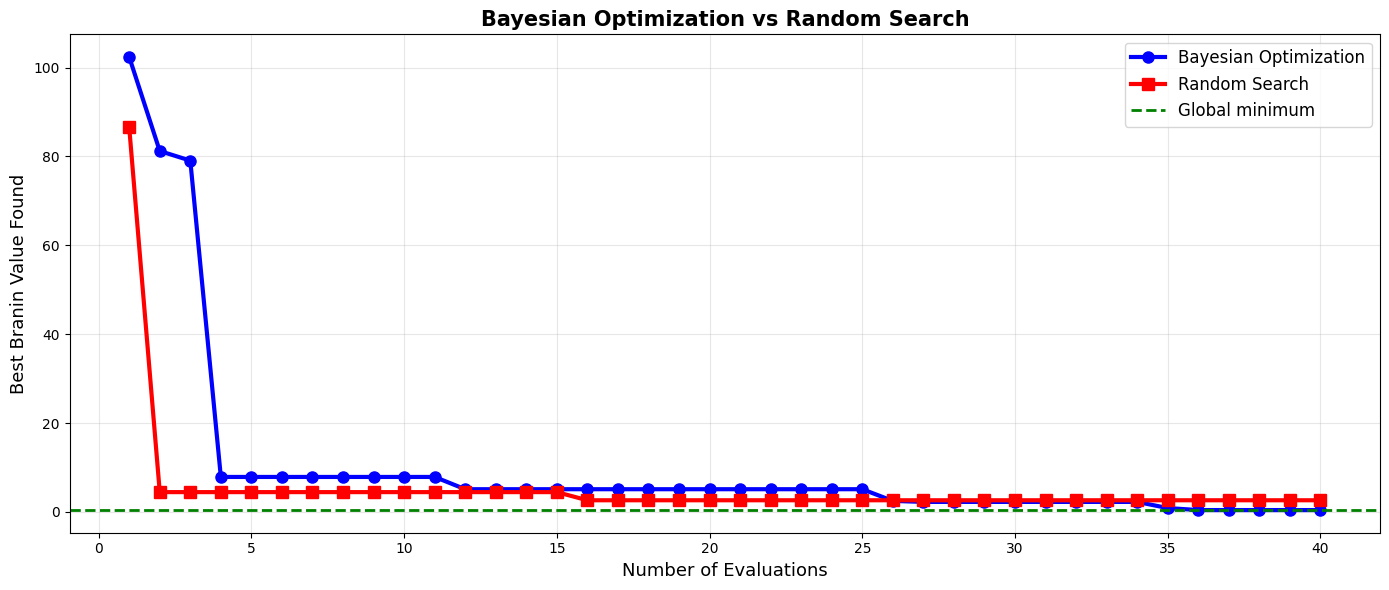


 Comparison after 40 evaluations:
 Bayesian Optimization: 0.4266
 Random Search: 2.6317
 BO is 83.8% better (found a lower minimum)


In [25]:
# Random search for comparison (same number of evaluations as BO)
n_random = 40
X_random = np.random.uniform([-5, 0], [10, 15], size=(n_random, 2))
y_random = [objective(x) for x in X_random]

best_random_idx = np.argmax(y_random)
best_random_value = -y_random[best_random_idx]

# Convergence comparison
random_convergence = [np.max(y_random[:i+1]) for i in range(len(y_random))]

plt.figure(figsize=(14, 6))
plt.plot(iterations, -result['convergence'], 'b-', linewidth=3, marker='o', 
         markersize=8, label='Bayesian Optimization')
plt.plot(iterations, -np.array(random_convergence), 'r-', linewidth=3, marker='s',
         markersize=8, label='Random Search')
plt.axhline(y=0.398, color='green', linestyle='--', linewidth=2, label='Global minimum')

plt.xlabel('Number of Evaluations', fontsize=13)
plt.ylabel('Best Branin Value Found', fontsize=13)
plt.title('Bayesian Optimization vs Random Search', fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n Comparison after {n_random} evaluations:")
print(f" Bayesian Optimization: {-result['convergence'][-1]:.4f}")
print(f" Random Search: {best_random_value:.4f}")

# Calculate improvement correctly
bo_final = -result['convergence'][-1]
if bo_final < best_random_value:
    improvement = ((best_random_value - bo_final) / best_random_value * 100)
    print(f" BO is {improvement:.1f}% better (found a lower minimum)")
else:
    improvement = ((bo_final - best_random_value) / bo_final * 100)
    print(f" Random search is {improvement:.1f}% better")

## Summary

1.  Bayesian Optimization finds the optimum much faster than random search
2.  Uses GP to model the objective and acquisition function to choose next point
3.  Balances exploration (uncertain regions) vs exploitation (near best points)
4.  Perfect for expensive-to-evaluate functions (like hyperparameter tuning!)

**Next: Applying this to real ML - XGBoost hyperparameter tuning**